## Busca de pontos linha a linha por densidade

In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
import pandas as pd

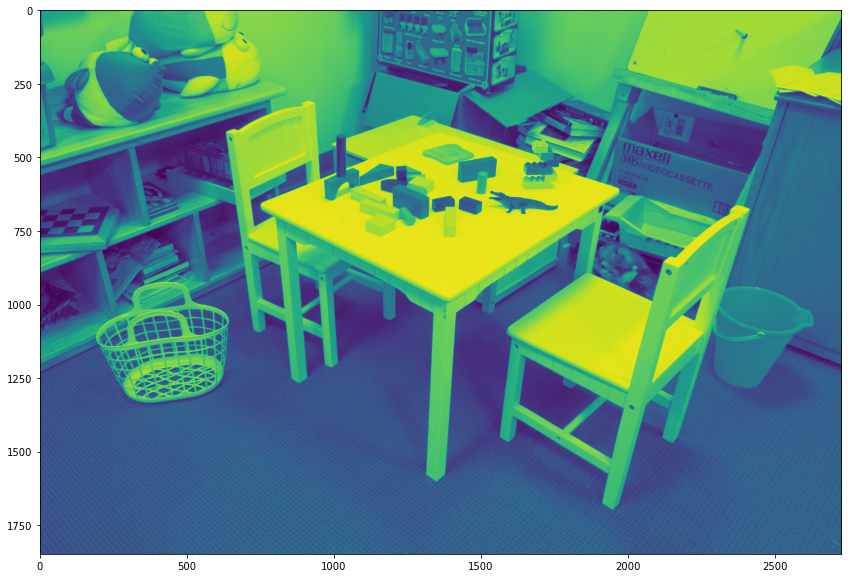

In [3]:
fig, ax = plt.subplots(figsize=(20, 10))

imgL = cv.imread('stereo_data/data/Middlebury/Playtable-perfect/im0.png',0)
imgR = cv.imread('stereo_data/data/Middlebury/Playtable-perfect/im1.png',0)

plt.imshow(imgL)
plt.show()

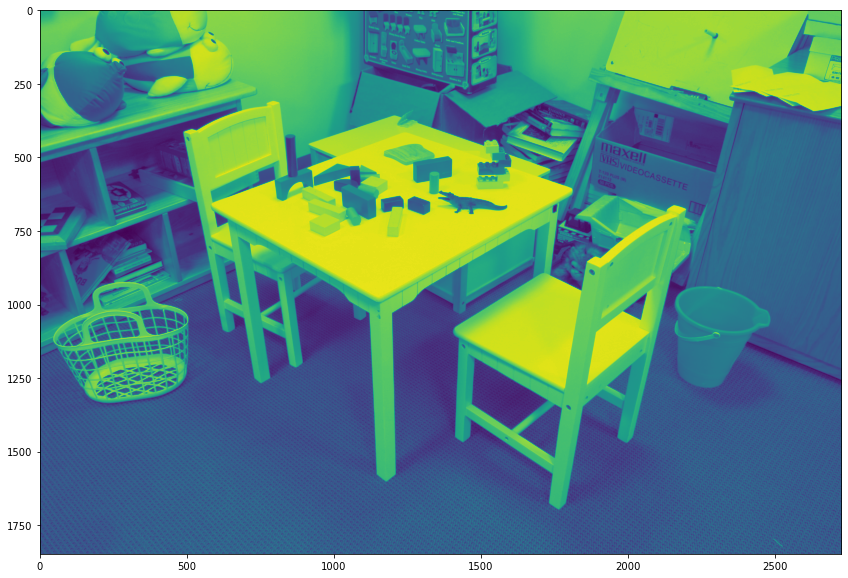

In [4]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(imgR)
plt.show()

In [5]:
imgL.shape

(1848, 2724)

### Pega primeiros 300 pixels de y e todos de x

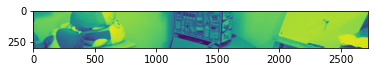

In [6]:
plt.imshow(imgL[:300,:])
plt.show()

### Seleciona alguns pontos da imagem da esquerda


In [6]:
#primeiros 5 pontos da imagem
#f2 = imgL[0,0:20]

# 5 pontos a partir do ponto 1
#f2 = imgL[0,1:6]

# Linha 250
# pontos 0 a 250
f2 = imgL[250,0:250]
f2

array([155, 150, 145, 140, 135, 132, 131, 128, 127, 126, 122, 121, 120,
       119, 119, 117, 118, 118, 119, 122, 127, 132, 138, 144, 148, 151,
       154, 154, 157, 159, 158, 159, 159, 161, 162, 162, 162, 161, 161,
       161, 160, 159, 160, 160, 161, 160, 160, 158, 158, 159, 158, 157,
       156, 158, 157, 157, 155, 155, 155, 157, 157, 158, 157, 157, 157,
       158, 158, 158, 156, 158, 159, 159, 158, 159, 159, 162, 161, 160,
       162, 161, 159, 157, 156, 156, 105,  70,  64,  64,  68,  73,  78,
        82,  86,  87,  85,  82,  74,  68,  67,  67,  69,  69,  70,  73,
        74,  77,  81,  82,  86,  90,  93,  97, 100, 103, 104, 105, 108,
       108, 108, 106, 101,  92,  80,  70,  62,  61,  65,  69,  75,  78,
        84,  87,  90,  92,  94,  94,  96,  96,  95,  94,  93,  92,  93,
        93,  92,  91,  90,  90,  90,  89,  89,  88,  90,  91,  93,  94,
       103, 125, 149, 169, 180, 185, 188, 189, 192, 193, 196, 197, 199,
       199, 198, 198, 200, 202, 201, 204, 204, 203, 204, 204, 20

### Seleciona a linha inteira da imagem da direita, para fazer o match

In [7]:
f1 =imgR[250,:]
f1

array([ 93,  92,  92, ..., 218, 223, 227], dtype=uint8)

### Realiza uma busca da menor distância quadrada em uma linha, através de convolução 1d

In [8]:
f1_squared = f1**2
f2_squared_sum = np.sum(f2**2)
nBuf = len(f2)
cross_terms = -2*np.convolve(f1, f2[::-1], "valid")
# reverse f2 to get what we want. 
# "valid" returns  where vectors completely overlap
squared_distance = [f2_squared_sum + np.sum(f1_squared[i:i+nBuf]) + cross_terms[i] 
                    for i in range(len(cross_terms))]
mean_squared_distance = np.array(squared_distance)/nBuf

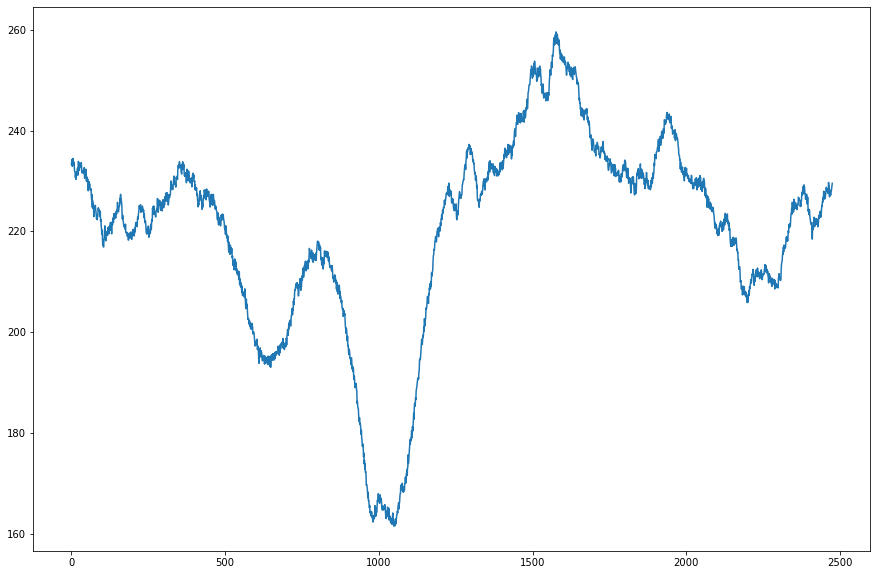

In [9]:
pd.Series(mean_squared_distance).plot.line(figsize=(15,10));

## Resultado péssimo pois não há esses pontos na imagem da direita
Como eu selecionei do ponto 0 ao ponto 250, o ponto 0 não está presente na imagem da direita, devido ao deslocamento da câmera

In [10]:
pd.Series(mean_squared_distance).nsmallest(5)

1048    161.552
1052    161.584
1049    161.724
1051    161.776
1042    161.932
dtype: float64

In [11]:
np.mean(pd.Series(mean_squared_distance).nsmallest(10).index)

1041.5

### Seleciona somente um pedaço da linha da imagem da direita
Para fazer a busca na imagem da Direita, pega do x= 0 até o ponto final da imagem da esquerda, ainda sem usar o max_disp

### Além disso, seleciona um ponto mais para a direita (da imagem da esquerda), para ele existir na imagem da direita

In [12]:
line = 500
x_start = 900
x_end = 950
f2 = imgL[line,x_start:x_end]
f2

array([216, 216, 216, 217, 216, 216, 216, 217, 217, 217, 217, 217, 217,
       215, 215, 216, 217, 217, 218, 219, 220, 222, 224, 225, 225, 222,
       217, 214, 213, 214, 214, 214, 214, 213, 213, 214, 213, 214, 213,
       213, 213, 213, 212, 211, 212, 212, 173, 101,  73,  67], dtype=uint8)

In [13]:
f1 =imgR[line,:x_end]
# f1

### Refaz a busca da menor distância

In [14]:
f1_squared = f1**2
f2_squared_sum = np.sum(f2**2)
nBuf = len(f2)
cross_terms = -2*np.convolve(f1, f2[::-1], "valid")
# reverse f2 to get what we want. 
# "valid" returns  where vectors completely overlap
squared_distance = [f2_squared_sum + np.sum(f1_squared[i:i+nBuf]) + cross_terms[i] 
                    for i in range(len(cross_terms))]
mean_squared_distance = np.array(squared_distance)/nBuf

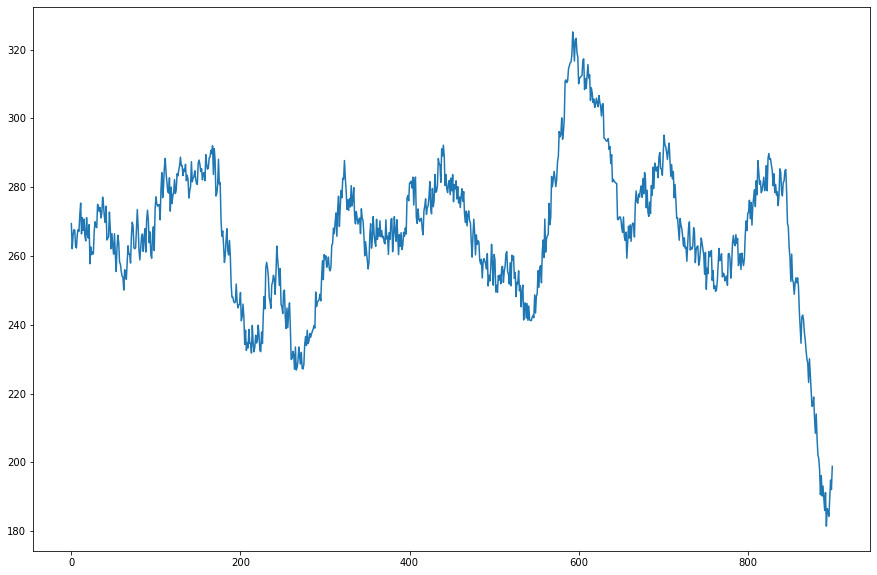

In [15]:
pd.Series(mean_squared_distance).plot.line(figsize=(15,10));

### Encontra os pontos com menor distância (mais similares)

In [16]:
pd.Series(mean_squared_distance).nsmallest(2)

893    181.46
896    184.32
dtype: float64

### retorna a média dos índices (heurística maluca)

In [17]:
x_start_right_image = np.mean(pd.Series(mean_squared_distance).nsmallest(2).index)
x_start_right_image

894.5

### Calcula disparidade do ponto

In [18]:
disparity = np.abs(x_start - x_start_right_image)
disparity

5.5

## Repete o processo para um ponto mais abaixo (mais a frente na imagem)

In [19]:
line = 1000
x_start = 1250
x_end = 1300
f2 = imgL[line,x_start:x_end]

f1 =imgR[line,:x_end]


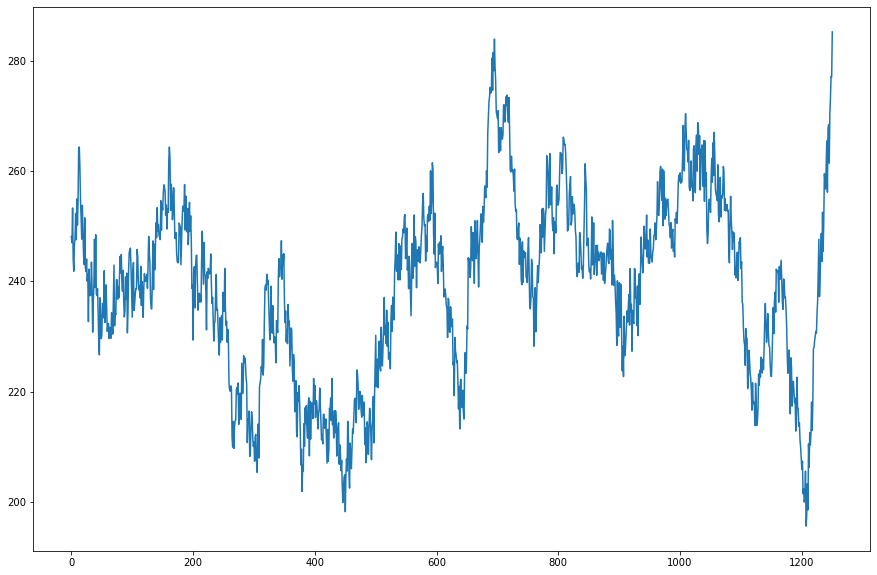

In [20]:
f1_squared = f1**2
f2_squared_sum = np.sum(f2**2)
nBuf = len(f2)
cross_terms = -2*np.convolve(f1, f2[::-1], "valid")
# reverse f2 to get what we want. 
# "valid" returns  where vectors completely overlap
squared_distance = [f2_squared_sum + np.sum(f1_squared[i:i+nBuf]) + cross_terms[i] 
                    for i in range(len(cross_terms))]
mean_squared_distance = np.array(squared_distance)/nBuf

pd.Series(mean_squared_distance).plot.line(figsize=(15,10));

In [21]:
pd.Series(mean_squared_distance).nsmallest(2)

1207    195.70
1208    197.58
dtype: float64

In [22]:
x_start_right_image = np.mean(pd.Series(mean_squared_distance).nsmallest(2).index)
x_start_right_image

1207.5

In [23]:
disparity = np.abs(x_start - x_start_right_image)
disparity

42.5

## Funciona porém a ambiguidade vai ser difícil de trabalhar.
### Por essa razão, vamos partir para fazer por regiões 2d da imagem

## Conv2d

In [24]:
imgL = cv.imread('stereo_data/data/Middlebury/Playtable-perfect/im0.png')
imgL = cv.cvtColor(imgL, cv.COLOR_BGR2GRAY)

In [25]:
imgL.shape

(1848, 2724)

In [13]:
#sharpen 2D
kernel = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0],
])

#blurr 2D
kernel = np.array([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625],
])


In [27]:
## ruim: com laço for
def convolution2d(image, kernel, bias):
    m, n = kernel.shape
    if (m == n):
        y, x = image.shape
        y = y - m + 1
        x = x - m + 1
        new_image = np.zeros((y,x))
        for i in range(y):
            for j in range(x):
                new_image[i][j] = np.sum(image[i:i+m, j:j+m]*kernel) + bias
    return new_image

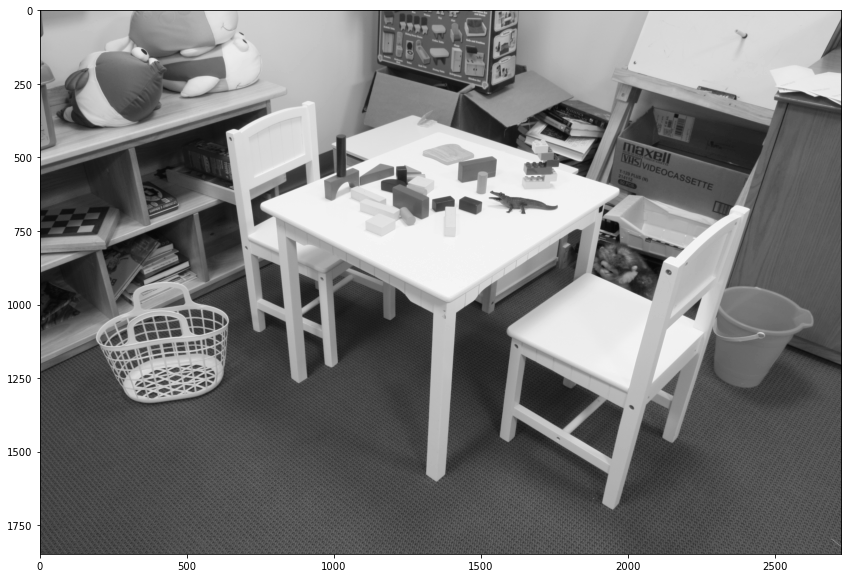

In [29]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(imgL[:,:],vmin=0, vmax=255, cmap='gray')
plt.show()

In [30]:
## Convoluciona 2 vezes
conved_image = convolution2d(imgL, kernel, 0)
conved_image = convolution2d(conved_image, kernel, 0)


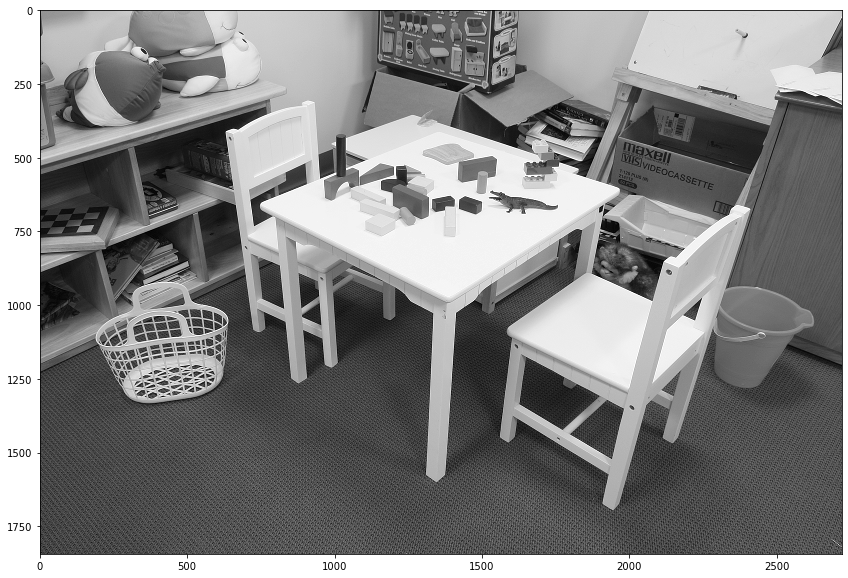

In [31]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(conved_image,vmin=0, vmax=255, cmap='gray')
plt.show()

In [32]:
imgL.shape

(1848, 2724)

In [33]:
conved_image.shape

(1844, 2720)

In [16]:
from scipy import ndimage

new_img = ndimage.convolve(imgL, kernel, mode='constant', cval=0.0)

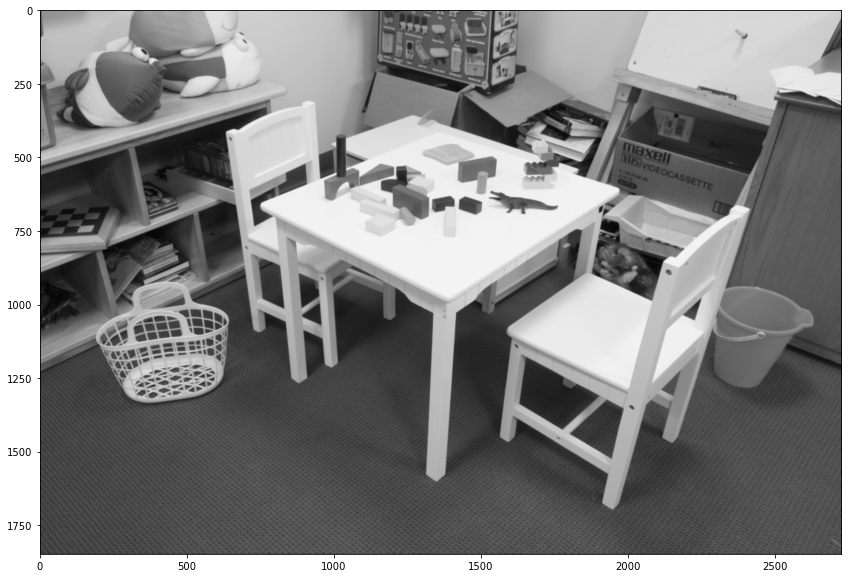

In [17]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(new_img,vmin=0, vmax=255, cmap='gray')
plt.show()